In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.qip.circuit import gate_sequence_product, QubitCircuit

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode

from sync_plots import calc_and_plot_Q_and_S


# Unitary Circuit

In [2]:
from sync_gates import unitary_circuit

In [3]:
dt = 0.1

detuning = 0.3
signal_strength = 0.2

In [4]:
qc = unitary_circuit(detuning, signal_strength, dt)

p = qc.propagators()
# Doesn't include the measurement or reset
D = gate_sequence_product(p)
D

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.99983751+0.01499869j  0.        +0.j          0.00999983+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99983751+0.01499869j  0.        +0.j
   0.00999983+0.j        ]
 [-0.00999983+0.j          0.        +0.j          0.99983751-0.01499869j
   0.        +0.j        ]
 [ 0.        +0.j         -0.00999983+0.j          0.        +0.j
   0.99983751-0.01499869j]]

## Simulation

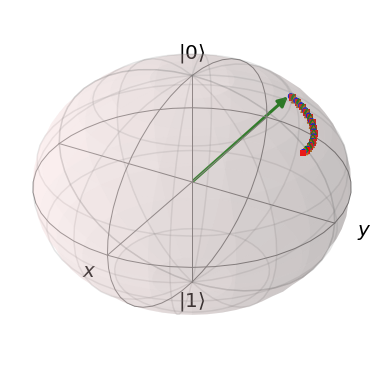

In [5]:
from sync_gates import run_simu

iq_state = (
    3 * np.exp(1j * 1) * basis(2, 0) 
    + np.exp(1j * -np.pi) * basis(2, 1)
).unit()
initial_state = tensor(iq_state, basis(2, 0))

b = Bloch()
b.add_states(initial_state.ptrace(0))

b.add_states([state.ptrace(0) for state in run_simu(qc, 50, initial_state)], kind="point")

b.show()


(<matplotlib.contour.QuadContourSet at 0x20f9e83f880>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

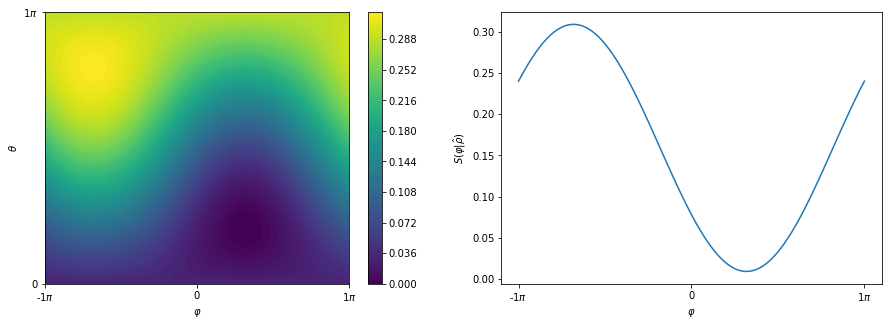

In [6]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

final_state = initial_state.ptrace(0)

Q = spin_husimi_qfunc(final_state, theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

In [7]:
final_state

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.9       +0.j        -0.16209069-0.2524413j]
 [-0.16209069+0.2524413j  0.1       +0.j       ]]

# Loss Circuit

In [8]:
from sync_gates import unitary_and_damping_circuit

In [9]:
detuning = 0.3
signal_strength = 0.2
dt = 0.1
Gamma_d = 1

theta_d = 2*np.arcsin(np.sqrt(Gamma_d * dt))

In [10]:
qc = unitary_and_damping_circuit(detuning, signal_strength, dt, theta_d)

# p = qc.propagators()
# # Doesn't include the measurement or reset
# D = gate_sequence_product(p)
# D

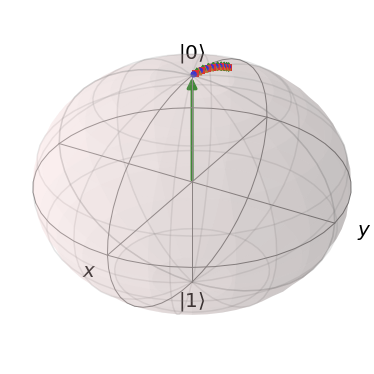

In [11]:
from sync_gates import run_simu

initial_state = tensor(basis(2, 0), basis(2, 0))

b = Bloch()
b.add_states(initial_state.ptrace(0))

states = [state.ptrace(0) for state in run_simu(qc, 35, initial_state)][::]

b.add_states(states, kind="point")

b.show()


In [12]:
# Probabilities
[expect(basis(2,0) * basis(2,0).dag(), states[-1]), expect(basis(2,1) * basis(2,1).dag(), states[-1])]

[0.9781682406957092, 0.021831759304291813]

In [13]:
states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.97816824+0.j         -0.13488353-0.05290562j]
 [-0.13488353+0.05290562j  0.02183176+0.j        ]]

(<matplotlib.contour.QuadContourSet at 0x20f9fe50190>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

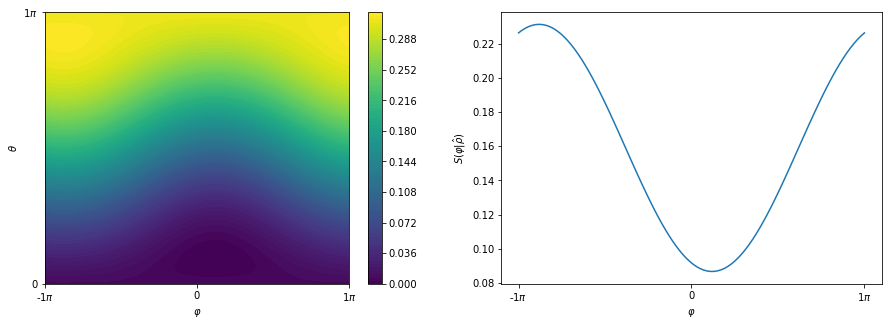

In [14]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(states[-1].ptrace(0), theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

# Gain & Loss Test

In [15]:
from sync_gates import dissipative_circuits

In [16]:
gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

In [17]:
def discrete_simulation(detuning, signal_strength, dt, theta_d, theta_g, steps):
    unit_evo_qc = unitary_circuit(detuning, signal_strength, dt)
    loss_qc, gain_qc = dissipative_circuits(theta_d, theta_g)

    initial_state = tensor(ket2dm(basis(2, 0)), ket2dm(basis(2, 0)))

    states = []

    start_state = initial_state
    for _ in range(steps):
        result = unit_evo_qc.run(state=start_state)

        result = loss_qc.run(state=tensor(result.ptrace(0), ket2dm(basis(2, 0))))  # & Reset
        result = gain_qc.run(state=tensor(result.ptrace(0), ket2dm(basis(2, 0))))  # & Reset

        state = result.ptrace(0)

        start_state = tensor(state, ket2dm(basis(2, 0)))  # Reset
        states.append(state)
    
    return states


In [18]:
states = discrete_simulation(detuning, signal_strength, dt, theta_d, theta_g, steps=35)

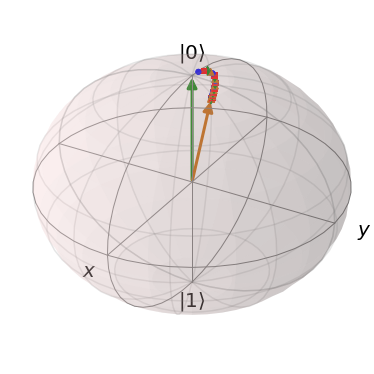

In [19]:
# Plot Bloch sphere rep of states
b = Bloch()

# b.add_states(initial_state.ptrace(0))
# b.add_states(states, kind="point")
# b.add_states(states[-1])

b.add_states(initial_state.ptrace(0))
b.add_states(states, "point") # Find a point with a good aproximation of the steady state 
b.add_states(states[-1])

b.show()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.8584966 +0.j         -0.06805415-0.02807356j]
 [-0.06805415+0.02807356j  0.1415034 +0.j        ]]

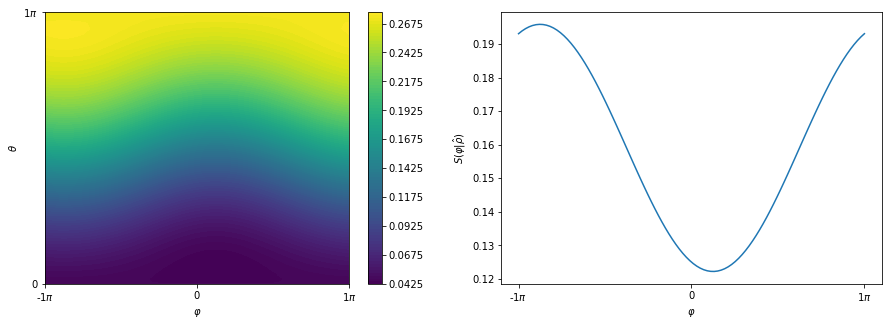

In [20]:
ss = states[-1]
calc_and_plot_Q_and_S(ss, method="qutip")
ss

# Arnold Tongue

In [21]:
n = 15
Gamma_g = 1
Gamma_d = 0.1
theta_d = 2*np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2*np.arcsin(np.sqrt(gain_amp * dt))

Smax = np.zeros([2 * n, n])

DR = 1
detunings = np.linspace(-DR, DR, 2*n)

ER = 1
strengths = np.linspace(0, ER, n)

m = 25
theta = np.linspace(0, np.pi, m)
phi = np.linspace(-np.pi, np.pi, 2 * m).reshape(-1, 1)

for i, D in enumerate(detunings):
    for j, E in enumerate(strengths):
        states = discrete_simulation(D, E, dt, theta_d, theta_g, steps=40)
        state = states[-1].full()

        # Swap around dm parts to give correct orientation
        # s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
        # s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
        Q = spin_husimi_qfunc(state, theta, phi)
        S = spin_S_measure(theta, Q)

        Smax[i, j] = np.max(S)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 100)
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)